In [1]:
#   ___                  _                
#  / _/______ ____  ____(_)__ _______     
# / _/ __/ _ `/ _ \/ __/ (_-</ __/ _ \    
#/_//_/  \_,_/_//_/\__/_/___/\__/\___/    
# ___ _____(_)__ ___ ____  / /_(_)       
# / _ `/ __/ (_-</ _ `/ _ \/ __/ /        
# \_, /_/ /_/___/\_,_/_//_/\__/_/         
#/___/
#
#Samee Lab @ Baylor College Of Medicine
#francisco.grisanticanozo@bcm.edu

In [2]:
import psutil
import platform
from datetime import datetime

print("="*20, "System Information", "="*20)
uname = platform.uname()
print(f"System: {uname.system}")
print(f"Node Name: {uname.node}")
print(f"Release: {uname.release}")
print(f"Version: {uname.version}")
print(f"Machine: {uname.machine}")

==================== System Information ====================
System: Linux
Node Name: martinlab-bobbyd
Release: 4.15.0-142-generic
Version: #146-Ubuntu SMP Tue Apr 13 01:11:19 UTC 2021
Machine: x86_64


In [23]:
#Load libraries
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import sys
import pandas as pd
import warnings
import seaborn as sb
import sklearn
import tqdm
import scanpy as sc
sc.settings.set_figure_params(dpi=200, facecolor='white')

# Import raw data / Pre-process it

In [51]:
# Load data
adata = sc.read('../Data/Tabula_Sapiens/TS_Lung.h5ad')

# Delete unnecessary layers
del adata.layers
del adata.raw


adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata,
                           qc_vars=['mt'], 
                           percent_top=None,
                           log1p=False,
                           inplace=True)

#Basic pre-processing
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

# Filter to top n HVG Genes
sc.pp.highly_variable_genes(adata,
                            n_top_genes=15000,
                            #flavor='seurat_v3',
                            batch_key="Donor")


sc.pp.regress_out(adata, ['total_counts','pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

#prune to only celltypes with more than 1000

counts = pd.DataFrame(adata.obs.Annotation.value_counts())
celltypes_to_keep = list(counts[counts.Annotation > 1000].index)
adata = adata[adata.obs['Annotation'].isin(celltypes_to_keep),:]


genes_to_keep = list(adata.var[adata.var['highly_variable']==True].index)
adata = adata[:,genes_to_keep]

# Filter to 1000 cells per class
#target_cells = 3000
#cluster_key = 'Donor'
#adata = [adata[adata.obs[cluster_key].isin([clust])] for clust in adata.obs[cluster_key].cat.categories]
#for dat in adata:
#    if dat.n_obs > target_cells:
#         sc.pp.subsample(dat, n_obs=target_cells)
#adata = adata[0].concatenate(*adata[1:])

# Set target feature

adata.obs['celltype'] = adata.obs['Annotation']

# Save train/predict datasets
adata[adata.obs['Donor'].isin(['TSP2']),:].write('../Data/Tabula_Sapiens/adata_train.h5ad')
adata[adata.obs['Donor'].isin(['TSP1']),:].write('../Data/Tabula_Sapiens/adata_predict.h5ad')

/home/franciscog/.conda/envs/STANN/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
Trying to set attribute `.obs` of view, copying.


# Vizualize data

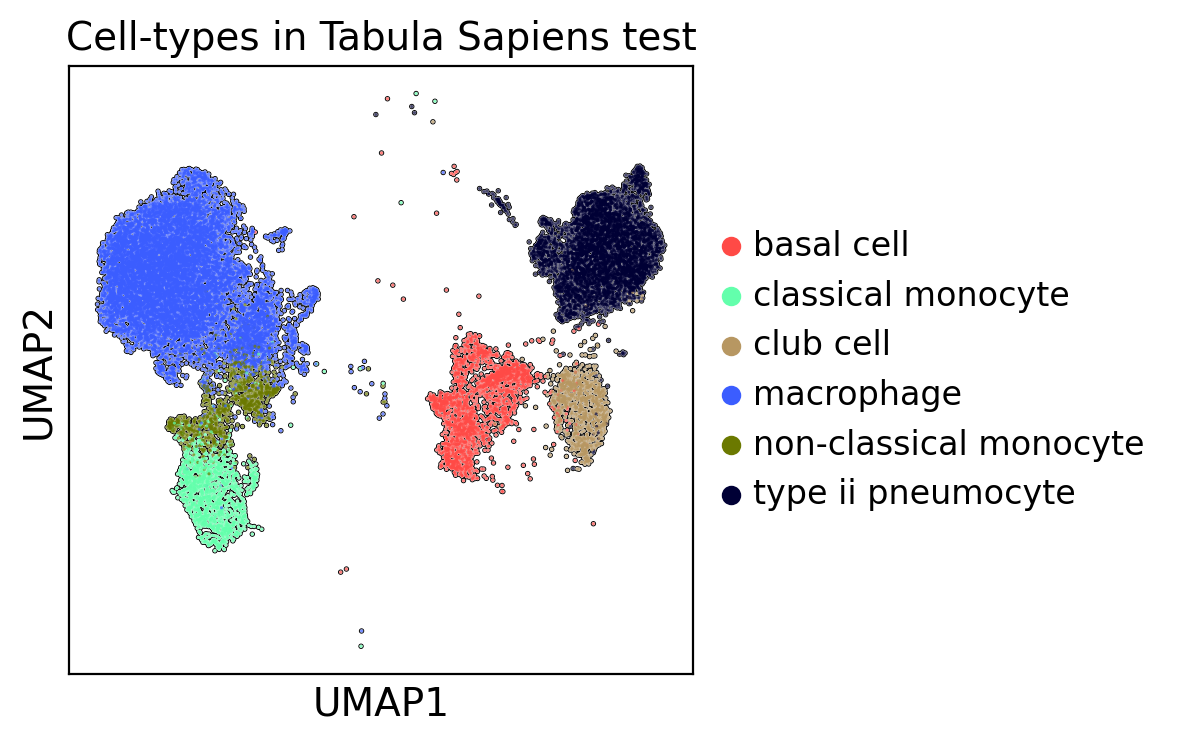

In [30]:
sc.pl.umap(adata, 
           color=['Annotation'],
           add_outline=True,
           legend_fontsize=12,
           title='Cell-types in Tabula Sapiens test')